<a href="https://colab.research.google.com/github/KenObata/TISMIR_notebooks/blob/main/week14_Glove_SVM_KFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week14: This notebook uses Glove word matrix-> SMOTE. Four models of Glove Word2Vec are tested.

Situation: English only (=multi-class).

Split: StratifiedKfold.



### set up

In [ ]:
!pip3 install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix

### Data Preparation(Kfold split)

Create dataframe for Gensim

In [ ]:
import pandas as pd

DIR = '/content/drive/MyDrive/music4all/'
df_genre_by_lang = pd.read_csv(DIR + 'df_genre_by_lang_full.csv')
df_genre_by_lang

,Unnamed: 0,id,genres,lang,lyric,number_of_line
0,0,0009fFIM1eYThaPg,pop,en,a sunny day so I got nowhere to hide Not a clo...,91
1,1,00P2bHdWFkghmDqz,soul,en,Tell me a tale that always was Sing me a song ...,36
2,2,00b6fV3nx5z2b8Ls,pop,en,A buh A buh You went to school to learn girl T...,74
3,3,013QDoTqbexEwkHr,pop,en,like a conversation where stops to breathe Is ...,20
4,4,01EKNot8qVgZpKM7,rock,en,Say the words I cannot say Say them on another...,31
...,...,...,...,...,...,...
13535,13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18
13536,13536,zzgS4ZqyswamEWNj,pop,en,Oh yeah yeah Last night I took a walk in the s...,75
13537,13537,zzx8CWdM7qkxKQpC,indie rock,en,Innocence it come easy in a sense it never wil...,34
13538,13538,zzz0n04uuTUA7fNh,pop,en,Girl you know how I feel I really Since you be...,65


In [ ]:
def load_data(df_col, y):
    texts, labels = [], []
    
    for line in df_col:
        # texts are already tokenized, just split on space
        # in a real use-case we would put more effort in preprocessing
        texts.append(line.split(' '))
    return pd.DataFrame({'texts': texts, 'labels': y})

In [ ]:
data = load_data(df_genre_by_lang["lyric"], df_genre_by_lang["genres"])

In [ ]:
data

,texts,labels
0,"[a, sunny, day, so, I, got, nowhere, to, hide,...",pop
1,"[Tell, me, a, tale, that, always, was, Sing, m...",soul
2,"[A, buh, A, buh, You, went, to, school, to, le...",pop
3,"[like, a, conversation, where, stops, to, brea...",pop
4,"[Say, the, words, I, cannot, say, Say, them, o...",rock
...,...,...
13535,"[think, what, afraid, of, come, in, you, know,...",indie rock
13536,"[Oh, yeah, yeah, Last, night, I, took, a, walk...",pop
13537,"[Innocence, it, come, easy, in, a, sense, it, ...",indie rock
13538,"[Girl, you, know, how, I, feel, I, really, Sin...",pop


In [ ]:
data['labels'] = data['labels'].astype('category')
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['texts']
y = data['labels']

In [ ]:
type(X)

pandas.core.series.Series

In [ ]:
def StratifiedKFold_feature_and_df_glove(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
def StratifiedKFold_feature_and_df(X, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  #y = df[y_name]
  skf.get_n_splits(X, y)#df[ feature_list ]

  splits = []

  for train_index, test_index in skf.split(X, y):#df[ feature_list ]
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
#feature_list = ["texts"] #this is BOW and TF-IDF
#splits = StratifiedKFold_feature_and_df( data, feature_list, 'labels')
splits = StratifiedKFold_feature_and_df( X,y)

TRAIN: [    0     1     3 ... 13537 13538 13539] TEST: [    2     4     5 ... 13526 13532 13535]
TRAIN: [    0     2     4 ... 13535 13536 13539] TEST: [    1     3     7 ... 13530 13537 13538]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [    8    14    22 ... 13521 13531 13536]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [   10    12    15 ... 13523 13525 13534]
TRAIN: [    1     2     3 ... 13536 13537 13538] TEST: [    0     6    11 ... 13529 13533 13539]


In [ ]:
len(splits)

5

In [ ]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(10832,)
(10832,)
(2708,)
(2708,)


In [ ]:
split0['X_train']

0        [a, sunny, day, so, I, got, nowhere, to, hide,...
1        [Tell, me, a, tale, that, always, was, Sing, m...
3        [like, a, conversation, where, stops, to, brea...
6        [Locked, up, tight, Like, I, would, never, fee...
7        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
13534    [grandma, cookies, nigga, Shout, out, to, fron...
13536    [Oh, yeah, yeah, Last, night, I, took, a, walk...
13537    [Innocence, it, come, easy, in, a, sense, it, ...
13538    [Girl, you, know, how, I, feel, I, really, Sin...
13539    [wwI, oh, must, go, on, standing, You, break, ...
Name: texts, Length: 10832, dtype: object

In [ ]:
split0['y_train']

0        4
1        9
3        4
6        4
7        6
        ..
13534    6
13536    4
13537    3
13538    4
13539    8
Name: labels, Length: 10832, dtype: int8

### (Part1) Gensim Implementation

Parameter

sg=1 means to use skip-gram

min_count... is a threashhold that the algorithm requires a word need to appear at least x time ot be considered as part of skip-gram algorithm.

size... is the # of dimensions.

iterations ... ?


In [ ]:
GLOVE_ZIP_FILE ="drive/MyDrive/music4all/glove.6B.zip"

!unzip drive/MyDrive/music4all/glove.6B.zip -d /content/

Archive:  drive/MyDrive/music4all/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


### Gensim Word2Vec Class

Ref:https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights
Ref:https://gist.github.com/AbhishekAshokDubey/054af6f92d67d5ef8300fac58f59fcc9


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec, Phrases, phrases, KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    Word vectors are averaged across to create the document-level vectors/features.
    gensim's own gensim.sklearn_api.W2VTransformer doesn't support out of vocabulary words,
    hence we roll out our own.
    All the parameters are gensim.models.Word2Vec's parameters.
    https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
    """
    
    def __init__(self, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, iter=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            size=self.size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, iter=self.iter, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)

        #My code added
        #google_wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        #Ref: https://radimrehurek.com/gensim/scripts/glove2word2vec.html
        

        print("Created glove_wv.")
        print("Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab : ", len(self.model_.wv.vocab))

        #self.model_.build_vocab(X)
        training_examples_count = self.model_.corpus_count
        print("original training_examples_count:", training_examples_count)
        print("Before merge, vocab: ", len(self.model_.wv.vocab))

        if self.size ==100:
          # load the Stanford GloVe model
          glove_input_file = 'glove.6B.100d.txt'
          word2vec_output_file = 'glove.6B.100d.txt.word2vec'
          glove2word2vec(glove_input_file, word2vec_output_file)
          filename = word2vec_output_file
          glove_wv = KeyedVectors.load_word2vec_format(filename, binary=False)
        elif self.size ==200:
          glove_input_file = 'glove.6B.200d.txt'
          word2vec_output_file = 'glove.6B.200d.txt.word2vec'
          glove2word2vec(glove_input_file, word2vec_output_file)
          filename = word2vec_output_file
          glove_wv = KeyedVectors.load_word2vec_format(filename, binary=False)
        elif self.size ==300:
          glove_input_file = 'glove.6B.300d.txt'
          word2vec_output_file = 'glove.6B.300d.txt.word2vec'
          glove2word2vec(glove_input_file, word2vec_output_file)
          filename = word2vec_output_file
          glove_wv = KeyedVectors.load_word2vec_format(filename, binary=False)


        self.model_.build_vocab([list(glove_wv.vocab.keys())], update=True)
        print("Updated build_vocab by Glove.")
        #self.model_.intersect_word2vec_format(glove_file, binary=False, lockf=1.0)#try this
        self.model_.intersect_word2vec_format(filename, binary=False, lockf=1.0)
        print("intersect completed.")
        self.model_.train(X, total_examples=training_examples_count, epochs=self.model_.iter)

        print("After merge, vocab: ", len(self.model_.wv.vocab))
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv.vocab]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.size)

### Visualize Glove embedded lyric documents

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100]# , 200, 300, 400

for temp_size in SIZE_PARAMETER:
  
  print("=======SIZE: ", temp_size ,"========")
  #1.create model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
  #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)

  #2.create word embedding and vector representation for each song
  gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

  #2-1.I want to add vocab from Gloeve
  X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
  #print(X_embeddings_temp)
  
  #3.SMOTE on train
  X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])
  
  #3-1. undersample by eda
  X_embeddings_minor = gensim_word2vec_tr_temp.transform( X_train_eda )

=======SIZE:  100 ========
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


Visualize EDA data via Glove's embedded weight matrix

In [ ]:
del(df_word_vector2)

In [ ]:
print(X_embeddings_minor.shape, y_train_eda.shape)

(12240, 100) (12240,)


In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_word_vector2 = pd.DataFrame(X_embeddings_minor)

In [ ]:
type(y_train_eda)

pandas.core.series.Series

In [ ]:
df_word_vector2['y'] = -1
for i, (_, genre_code) in enumerate(y_train_eda.items()):
  df_word_vector2.loc[i, 'y'] = genre_code

In [ ]:
df_word_vector2.shape

(12240, 101)

In [ ]:
feature_cols = [ num for num in range(0,100)]
pca2 = PCA(n_components=3)
pca_result2 = pca2.fit_transform(df_word_vector2[feature_cols].values)

df_word_vector2['pca-one'] = pca_result2[:,0]
df_word_vector2['pca-two'] = pca_result2[:,1] 
df_word_vector2['pca-three'] = pca_result2[:,2]

print('Explained variation per principal component: {}'.format(pca2.explained_variance_ratio_))

Explained variation per principal component: [0.09708969 0.05725645 0.04293769]


In [ ]:
number_of_y = len(set(df_word_vector2["y"]))
number_of_y

10

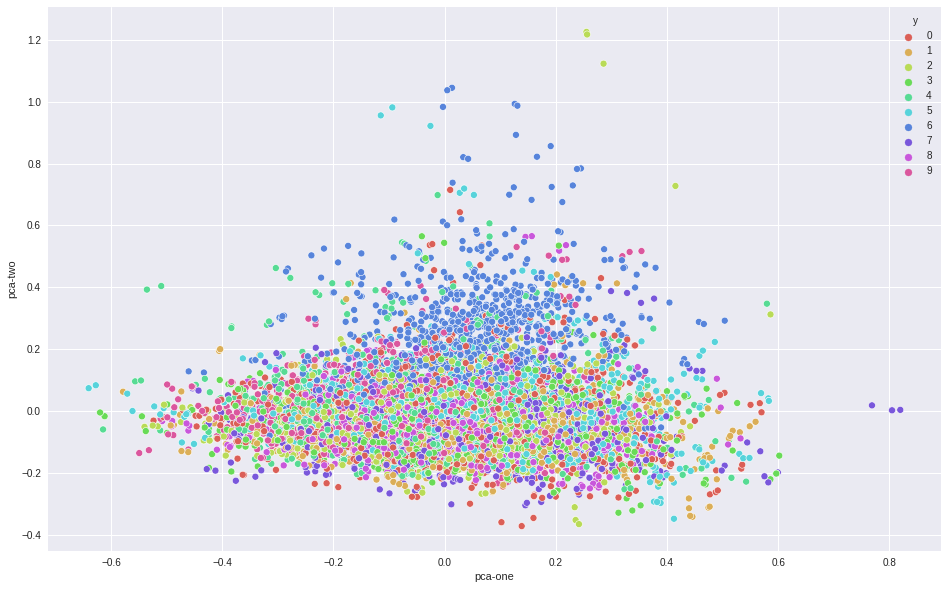

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_word_vector2.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", number_of_y),
    data=df_word_vector2.loc[rndperm,:],
    legend="full",
    alpha=1
)

### Visualize original lyrics document (X_embeddings_temp) via Glove weight matrix

In [ ]:
del(df_word_vector3)

In [ ]:
print(X_embeddings_temp.shape, split0['y_train'].shape)

(10832, 100) (10832,)


In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_word_vector3 = pd.DataFrame(X_embeddings_temp)

In [ ]:
df_word_vector3.shape

(10832, 100)

In [ ]:
type(split0['y_train'])

pandas.core.series.Series

In [ ]:
df_word_vector3['y'] = -1
print(df_word_vector3.shape)

(10832, 101)


In [ ]:
for i, (_, genre_code) in enumerate(split0['y_train'].items()):
  #print(i, genre_code)
  df_word_vector3.loc[i, 'y'] = genre_code

In [ ]:
df_word_vector3.shape

(10832, 101)

In [ ]:
feature_cols = [ num for num in range(0,100)]
pca3 = PCA(n_components=3)
pca_result3 = pca3.fit_transform(df_word_vector3[feature_cols].values)

df_word_vector3['pca-one'] = pca_result3[:,0]
df_word_vector3['pca-two'] = pca_result3[:,1] 
df_word_vector3['pca-three'] = pca_result3[:,2]

print('Explained variation per principal component: {}'.format(pca3.explained_variance_ratio_))

Explained variation per principal component: [0.08235912 0.0571936  0.04286555]


In [ ]:
number_of_y = len(set(df_word_vector3["y"]))
number_of_y

10

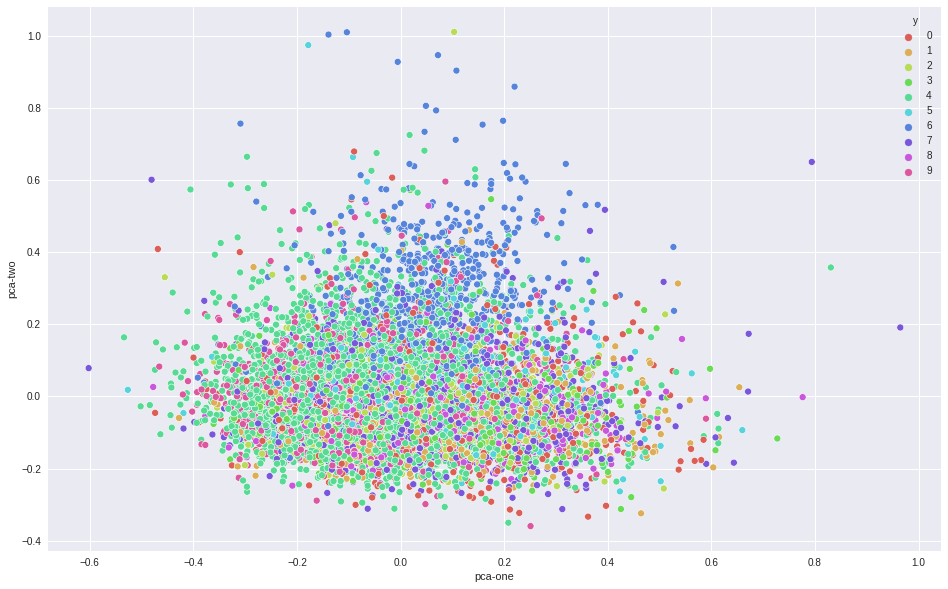

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_word_vector3.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", number_of_y),
    data=df_word_vector3.loc[rndperm,:],
    legend="full",
    alpha=1
)

### Visualize original data after SMOTE

In [ ]:
print(X_resampled_temp.shape, y_resampled_temp.shape)#X_resampled_temp, y_resampled_temp

(41430, 100) (41430,)


In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_word_vector4 = pd.DataFrame(X_resampled_temp)

In [ ]:
df_word_vector4.shape

(41430, 100)

In [ ]:
type(y_resampled_temp)

pandas.core.series.Series

In [ ]:
df_word_vector4['y'] = -1
print(df_word_vector4.shape)

(41430, 101)


In [ ]:
for i, (_, genre_code) in enumerate(y_resampled_temp.items()):
  #print(i, genre_code)
  df_word_vector4.loc[i, 'y'] = genre_code

In [ ]:
df_word_vector4.shape

(41430, 101)

In [ ]:
feature_cols = [ num for num in range(0,100)]
pca4 = PCA(n_components=3)
pca_result4 = pca4.fit_transform(df_word_vector4[feature_cols].values)

df_word_vector4['pca-one'] = pca_result4[:,0]
df_word_vector4['pca-two'] = pca_result4[:,1] 
df_word_vector4['pca-three'] = pca_result4[:,2]

print('Explained variation per principal component: {}'.format(pca4.explained_variance_ratio_))

Explained variation per principal component: [0.10478059 0.07526815 0.04039155]


In [ ]:
number_of_y = len(set(df_word_vector4["y"]))
number_of_y

10

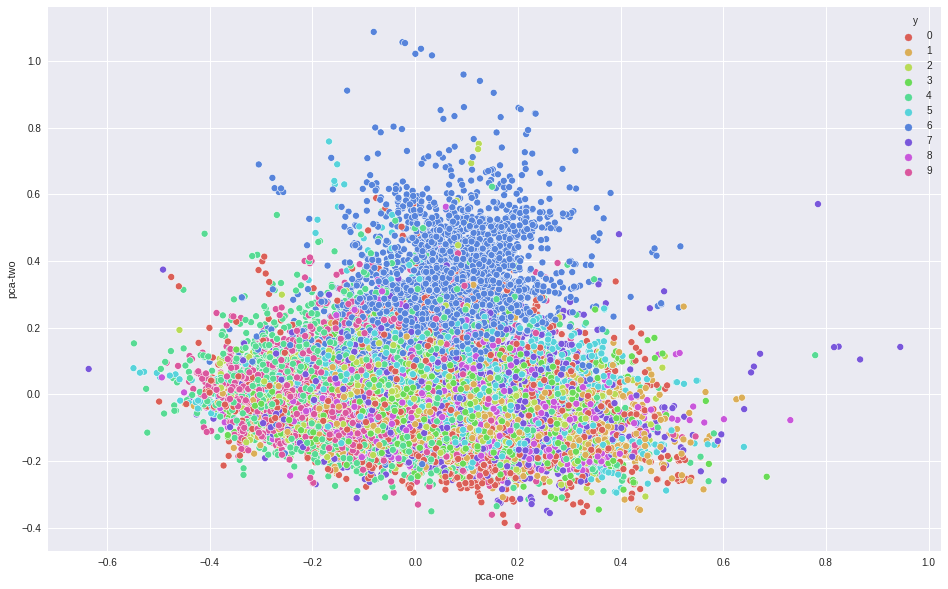

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_word_vector4.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", number_of_y),
    data=df_word_vector4.loc[rndperm,:],
    legend="full",
    alpha=1
)

### First, find best parameter of Glove SVM model, then later test KFold mean

In [ ]:
len(splits)

5

In [ ]:
def X_train_test_prepare(X_train, X_test):
  first_index =X_train.index[0]
  if type(X_train[first_index]) is not list:
    for idx, lyrics in X_train.items():
      X_train[idx] = lyrics.split(' ')

  first_index =X_test.index[0]
  if type(X_test[first_index]) is not list:
    for idx, lyrics in X_test.items():
      X_test[idx] = lyrics.split(' ')

  return X_train, X_test

In [ ]:
X_train_test_prepare()

In [ ]:
# List of C values
C_range = np.logspace(-1, 1, 3)
print(f'The list of values for C are {C_range}')
# List of gamma values
gamma_range = np.logspace(-1, 1, 3)
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [ 0.1  1.  10. ]
The list of values for gamma are [ 0.1  1.  10. ]


In [ ]:
C_list = C_range.tolist()
C_list

[0.1, 1.0, 10.0]

In [ ]:
gamma_list = gamma_range.tolist()+['scale', 'auto']
gamma_list

[0.1, 1.0, 10.0, 'scale', 'auto']

In [ ]:
kernel_list = ['rbf']#'poly',  'linear'
kernel_list

['rbf']

In [ ]:
SIZE_PARAMETER = [100, 200, 300]
#n_estimators = [100,200,300,400]
McNemar = {}
for temp_size in SIZE_PARAMETER:
    for kernel_choice in kernel_list:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )] = []
McNemar

{(0, 100, 'rbf', 0.1, 0.1): [],
 (0, 100, 'rbf', 0.1, 1.0): [],
 (0, 100, 'rbf', 0.1, 10.0): [],
 (0, 100, 'rbf', 1.0, 0.1): [],
 (0, 100, 'rbf', 1.0, 1.0): [],
 (0, 100, 'rbf', 1.0, 10.0): [],
 (0, 100, 'rbf', 10.0, 0.1): [],
 (0, 100, 'rbf', 10.0, 1.0): [],
 (0, 100, 'rbf', 10.0, 10.0): [],
 (0, 100, 'rbf', 'scale', 0.1): [],
 (0, 100, 'rbf', 'scale', 1.0): [],
 (0, 100, 'rbf', 'scale', 10.0): [],
 (0, 100, 'rbf', 'auto', 0.1): [],
 (0, 100, 'rbf', 'auto', 1.0): [],
 (0, 100, 'rbf', 'auto', 10.0): [],
 (0, 200, 'rbf', 0.1, 0.1): [],
 (0, 200, 'rbf', 0.1, 1.0): [],
 (0, 200, 'rbf', 0.1, 10.0): [],
 (0, 200, 'rbf', 1.0, 0.1): [],
 (0, 200, 'rbf', 1.0, 1.0): [],
 (0, 200, 'rbf', 1.0, 10.0): [],
 (0, 200, 'rbf', 10.0, 0.1): [],
 (0, 200, 'rbf', 10.0, 1.0): [],
 (0, 200, 'rbf', 10.0, 10.0): [],
 (0, 200, 'rbf', 'scale', 0.1): [],
 (0, 200, 'rbf', 'scale', 1.0): [],
 (0, 200, 'rbf', 'scale', 10.0): [],
 (0, 200, 'rbf', 'auto', 0.1): [],
 (0, 200, 'rbf', 'auto', 1.0): [],
 (0, 200, 'rbf', '

In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100]#, 200, 300

balanced_acc_by_dim = {100:[], 200:[], 300:[]}

for i in range(0,1):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
    for kernel_choice in kernel_list:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          print("==SIZE: ", temp_size, "==kernel:",kernel_choice, "==gamma:", gamma_choice, "==C:", C_choice)
          #1.create model and clf
          gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
          #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
          #Note: degree is only used for 'poly'
          clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)

          #2.create word embedding and vector representation for each song
          gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

          #2-1.I want to add vocab from Gloeve
          X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
          
          #3.SMOTE on train
          X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

          #4.train
          clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

          #5.Create test embedding and then predict
          #Note: this is because test embedding shape changes for each loop
          X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
          y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
          print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
          print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
          balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

          for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
            if ground_truth == pred:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(True)
            else:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(False)
        

==SIZE:  100 ==kernel: rbf ==gamma: 0.1 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.12      0.13       190
           1       0.18      0.38      0.25       173
           2       0.09      0.29      0.14       135
           3       0.20      0.20      0.20       216
           4       0.56      0.08      0.14      1036
           5       0.17      0.41      0.24        76
           6       0.67      0.68      0.68       195
           7       0.08      0.00      0.01       290
           8       0.12      0.05      0.07       139
           9       0.15      0.56      0.24       258

    accuracy                           0.21      2708
   macro avg       0.24      0.28      0.21      2708
weighted avg       0.34      0.21      0.18      2708

0.2767079232579879
==SIZE:  100 ==kernel: rbf ==gamma: 0.1 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.22      0.19       190
           1       0.19      0.34      0.25       173
           2       0.07      0.14      0.09       135
           3       0.18      0.13      0.15       216
           4       0.60      0.19      0.29      1036
           5       0.12      0.39      0.19        76
           6       0.67      0.75      0.71       195
           7       0.19      0.07      0.10       290
           8       0.13      0.17      0.15       139
           9       0.18      0.47      0.26       258

    accuracy                           0.25      2708
   macro avg       0.25      0.29      0.24      2708
weighted avg       0.37      0.25      0.26      2708

0.28721438515678555
==SIZE:  100 ==kernel: rbf ==gamma: 0.1 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.19      0.15       190
           1       0.21      0.33      0.26       173
           2       0.08      0.14      0.10       135
           3       0.16      0.14      0.15       216
           4       0.56      0.24      0.34      1036
           5       0.12      0.33      0.18        76
           6       0.68      0.78      0.73       195
           7       0.17      0.09      0.12       290
           8       0.12      0.14      0.13       139
           9       0.20      0.42      0.28       258

    accuracy                           0.27      2708
   macro avg       0.24      0.28      0.24      2708
weighted avg       0.35      0.27      0.28      2708

0.2798122062863354
==SIZE:  100 ==kernel: rbf ==gamma: 1.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.19      0.17       190
           1       0.22      0.38      0.28       173
           2       0.08      0.14      0.10       135
           3       0.21      0.13      0.16       216
           4       0.53      0.24      0.33      1036
           5       0.13      0.38      0.20        76
           6       0.68      0.74      0.71       195
           7       0.20      0.08      0.11       290
           8       0.13      0.16      0.15       139
           9       0.21      0.47      0.29       258

    accuracy                           0.27      2708
   macro avg       0.25      0.29      0.25      2708
weighted avg       0.35      0.27      0.28      2708

0.29252885138013374
==SIZE:  100 ==kernel: rbf ==gamma: 1.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.20      0.17       190
           1       0.23      0.36      0.28       173
           2       0.07      0.10      0.08       135
           3       0.16      0.17      0.16       216
           4       0.55      0.30      0.39      1036
           5       0.16      0.32      0.21        76
           6       0.70      0.77      0.73       195
           7       0.16      0.09      0.11       290
           8       0.16      0.19      0.18       139
           9       0.22      0.43      0.29       258

    accuracy                           0.29      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.35      0.29      0.30      2708

0.2931295204436152
==SIZE:  100 ==kernel: rbf ==gamma: 1.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.14      0.13       190
           1       0.20      0.28      0.24       173
           2       0.10      0.12      0.11       135
           3       0.15      0.18      0.17       216
           4       0.53      0.42      0.47      1036
           5       0.21      0.20      0.20        76
           6       0.76      0.76      0.76       195
           7       0.15      0.13      0.14       290
           8       0.15      0.14      0.14       139
           9       0.21      0.30      0.25       258

    accuracy                           0.32      2708
   macro avg       0.26      0.27      0.26      2708
weighted avg       0.35      0.32      0.33      2708

0.2669176219067199
==SIZE:  100 ==kernel: rbf ==gamma: 10.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.09      0.09      0.09       190
           1       0.24      0.16      0.19       173
           2       0.12      0.07      0.09       135
           3       0.22      0.12      0.15       216
           4       0.42      0.63      0.51      1036
           5       0.17      0.14      0.16        76
           6       0.80      0.63      0.70       195
           7       0.15      0.07      0.09       290
           8       0.23      0.08      0.12       139
           9       0.21      0.21      0.21       258

    accuracy                           0.35      2708
   macro avg       0.27      0.22      0.23      2708
weighted avg       0.32      0.35      0.32      2708

0.21984781861161853
==SIZE:  100 ==kernel: rbf ==gamma: 10.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.04      0.06       190
           1       0.28      0.21      0.24       173
           2       0.17      0.06      0.09       135
           3       0.21      0.12      0.16       216
           4       0.46      0.82      0.59      1036
           5       0.32      0.09      0.14        76
           6       0.82      0.68      0.74       195
           7       0.20      0.11      0.14       290
           8       0.32      0.09      0.14       139
           9       0.26      0.14      0.18       258

    accuracy                           0.42      2708
   macro avg       0.32      0.24      0.25      2708
weighted avg       0.36      0.42      0.36      2708

0.2350069902348523
==SIZE:  100 ==kernel: rbf ==gamma: 10.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.11      0.03      0.05       190
           1       0.28      0.18      0.22       173
           2       0.15      0.04      0.06       135
           3       0.24      0.15      0.18       216
           4       0.45      0.84      0.59      1036
           5       0.38      0.07      0.11        76
           6       0.85      0.68      0.75       195
           7       0.18      0.09      0.12       290
           8       0.34      0.07      0.12       139
           9       0.30      0.12      0.17       258

    accuracy                           0.42      2708
   macro avg       0.33      0.23      0.24      2708
weighted avg       0.36      0.42      0.35      2708

0.22597607384607898
==SIZE:  100 ==kernel: rbf ==gamma: scale ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.18      0.17       190
           1       0.23      0.40      0.29       173
           2       0.07      0.16      0.10       135
           3       0.18      0.12      0.14       216
           4       0.56      0.19      0.28      1036
           5       0.14      0.43      0.22        76
           6       0.71      0.73      0.72       195
           7       0.20      0.06      0.09       290
           8       0.09      0.10      0.10       139
           9       0.18      0.50      0.26       258

    accuracy                           0.25      2708
   macro avg       0.25      0.29      0.24      2708
weighted avg       0.36      0.25      0.25      2708

0.28829931072961934
==SIZE:  100 ==kernel: rbf ==gamma: scale ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.27      0.21       190
           1       0.21      0.32      0.25       173
           2       0.07      0.12      0.09       135
           3       0.17      0.14      0.15       216
           4       0.56      0.26      0.35      1036
           5       0.14      0.36      0.20        76
           6       0.71      0.78      0.75       195
           7       0.19      0.10      0.13       290
           8       0.14      0.18      0.16       139
           9       0.20      0.41      0.27       258

    accuracy                           0.28      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.36      0.28      0.29      2708

0.29401897003903815
==SIZE:  100 ==kernel: rbf ==gamma: scale ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_example

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.23      0.18       190
           1       0.23      0.33      0.27       173
           2       0.06      0.10      0.07       135
           3       0.15      0.14      0.15       216
           4       0.57      0.36      0.44      1036
           5       0.12      0.17      0.14        76
           6       0.71      0.76      0.74       195
           7       0.17      0.14      0.15       290
           8       0.14      0.14      0.14       139
           9       0.22      0.36      0.27       258

    accuracy                           0.31      2708
   macro avg       0.25      0.27      0.26      2708
weighted avg       0.36      0.31      0.32      2708

0.2728258966816652
==SIZE:  100 ==kernel: rbf ==gamma: auto ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.21      0.22      0.22       173
           2       0.07      0.19      0.10       135
           3       0.14      0.38      0.20       216
           4       0.40      0.00      0.00      1036
           5       0.43      0.08      0.13        76
           6       0.83      0.51      0.63       195
           7       0.00      0.00      0.00       290
           8       0.00      0.00      0.00       139
           9       0.13      0.74      0.22       258

    accuracy                           0.16      2708
   macro avg       0.22      0.21      0.15      2708
weighted avg       0.27      0.16      0.11      2708

0.2117722794059632
==SIZE:  100 ==kernel: rbf ==gamma: auto ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.11      0.13       190
           1       0.18      0.29      0.23       173
           2       0.09      0.29      0.14       135
           3       0.19      0.18      0.18       216
           4       0.59      0.10      0.17      1036
           5       0.16      0.41      0.23        76
           6       0.67      0.68      0.68       195
           7       0.21      0.01      0.03       290
           8       0.13      0.12      0.12       139
           9       0.15      0.56      0.24       258

    accuracy                           0.22      2708
   macro avg       0.25      0.28      0.21      2708
weighted avg       0.36      0.22      0.20      2708

0.2753106370340991
==SIZE:  100 ==kernel: rbf ==gamma: auto ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.19      0.16       190
           1       0.18      0.34      0.24       173
           2       0.09      0.18      0.12       135
           3       0.18      0.15      0.16       216
           4       0.62      0.20      0.30      1036
           5       0.14      0.42      0.22        76
           6       0.66      0.75      0.71       195
           7       0.18      0.08      0.11       290
           8       0.15      0.16      0.15       139
           9       0.20      0.49      0.28       258

    accuracy                           0.26      2708
   macro avg       0.26      0.30      0.24      2708
weighted avg       0.38      0.26      0.26      2708

0.2959047094003801
==SIZE:  100 ==kernel: poly ==gamma: 0.1 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.00      0.00      0.00       173
           2       0.00      0.00      0.00       135
           3       0.08      1.00      0.15       216
           4       0.00      0.00      0.00      1036
           5       0.00      0.00      0.00        76
           6       0.00      0.00      0.00       195
           7       0.00      0.00      0.00       290
           8       0.00      0.00      0.00       139
           9       0.00      0.00      0.00       258

    accuracy                           0.08      2708
   macro avg       0.01      0.10      0.01      2708
weighted avg       0.01      0.08      0.01      2708

0.1
==SIZE:  100 ==kernel: poly ==gamma: 0.1 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       1.00      0.01      0.01       173
           2       0.00      0.00      0.00       135
           3       0.08      1.00      0.15       216
           4       0.00      0.00      0.00      1036
           5       0.00      0.00      0.00        76
           6       0.00      0.00      0.00       195
           7       0.00      0.00      0.00       290
           8       0.00      0.00      0.00       139
           9       0.00      0.00      0.00       258

    accuracy                           0.08      2708
   macro avg       0.11      0.10      0.02      2708
weighted avg       0.07      0.08      0.01      2708

0.10057803468208093
==SIZE:  100 ==kernel: poly ==gamma: 0.1 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Update

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.00      0.00      0.00       173
           2       0.00      0.00      0.00       135
           3       0.08      1.00      0.15       216
           4       0.00      0.00      0.00      1036
           5       0.00      0.00      0.00        76
           6       0.00      0.00      0.00       195
           7       0.00      0.00      0.00       290
           8       0.00      0.00      0.00       139
           9       0.00      0.00      0.00       258

    accuracy                           0.08      2708
   macro avg       0.01      0.10      0.01      2708
weighted avg       0.01      0.08      0.01      2708

0.1
==SIZE:  100 ==kernel: poly ==gamma: 1.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.08      0.08      0.08       190
           1       0.18      0.20      0.19       173
           2       0.10      0.11      0.11       135
           3       0.17      0.17      0.17       216
           4       0.52      0.57      0.54      1036
           5       0.17      0.14      0.15        76
           6       0.70      0.76      0.73       195
           7       0.13      0.11      0.12       290
           8       0.18      0.13      0.15       139
           9       0.24      0.21      0.23       258

    accuracy                           0.35      2708
   macro avg       0.25      0.25      0.25      2708
weighted avg       0.34      0.35      0.34      2708

0.24828995397215975
==SIZE:  100 ==kernel: poly ==gamma: 1.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.11      0.12      0.11       190
           1       0.20      0.24      0.21       173
           2       0.09      0.10      0.09       135
           3       0.15      0.15      0.15       216
           4       0.52      0.56      0.54      1036
           5       0.17      0.12      0.14        76
           6       0.72      0.78      0.75       195
           7       0.14      0.12      0.13       290
           8       0.16      0.11      0.13       139
           9       0.21      0.19      0.20       258

    accuracy                           0.35      2708
   macro avg       0.25      0.25      0.25      2708
weighted avg       0.34      0.35      0.34      2708

0.24760912424047626
==SIZE:  100 ==kernel: poly ==gamma: 1.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.11      0.12      0.12       190
           1       0.19      0.24      0.21       173
           2       0.10      0.11      0.10       135
           3       0.13      0.13      0.13       216
           4       0.52      0.55      0.53      1036
           5       0.13      0.11      0.12        76
           6       0.70      0.73      0.72       195
           7       0.15      0.12      0.13       290
           8       0.14      0.11      0.12       139
           9       0.24      0.21      0.22       258

    accuracy                           0.34      2708
   macro avg       0.24      0.24      0.24      2708
weighted avg       0.33      0.34      0.34      2708

0.24152627854624753
==SIZE:  100 ==kernel: poly ==gamma: 10.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [200]#, 200, 300

balanced_acc_by_dim = {100:[], 200:[], 300:[]}

for i in range(0,1):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
    for kernel_choice in kernel_list:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          print("==SIZE: ", temp_size, "==kernel:",kernel_choice, "==gamma:", gamma_choice, "==C:", C_choice)
          #1.create model and clf
          gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
          #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
          #Note: degree is only used for 'poly'
          clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)

          #2.create word embedding and vector representation for each song
          gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

          #2-1.I want to add vocab from Gloeve
          X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
          
          #3.SMOTE on train
          X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

          #4.train
          clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

          #5.Create test embedding and then predict
          #Note: this is because test embedding shape changes for each loop
          X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
          y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
          print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
          print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
          balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

          for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
            if ground_truth == pred:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(True)
            else:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(False)
        

==SIZE:  200 ==kernel: rbf ==gamma: 0.1 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.18      0.11      0.13       190
           1       0.19      0.39      0.25       173
           2       0.10      0.33      0.15       135
           3       0.17      0.14      0.16       216
           4       0.56      0.10      0.17      1036
           5       0.17      0.39      0.23        76
           6       0.71      0.69      0.70       195
           7       0.20      0.01      0.02       290
           8       0.15      0.08      0.10       139
           9       0.15      0.57      0.24       258

    accuracy                           0.22      2708
   macro avg       0.26      0.28      0.22      2708
weighted avg       0.36      0.22      0.20      2708

0.28018987123386097
==SIZE:  200 ==kernel: rbf ==gamma: 0.1 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.16      0.23      0.19       190
           1       0.19      0.32      0.24       173
           2       0.12      0.19      0.15       135
           3       0.17      0.14      0.15       216
           4       0.60      0.25      0.35      1036
           5       0.12      0.34      0.18        76
           6       0.71      0.75      0.73       195
           7       0.19      0.09      0.13       290
           8       0.15      0.19      0.17       139
           9       0.20      0.44      0.27       258

    accuracy                           0.28      2708
   macro avg       0.26      0.30      0.26      2708
weighted avg       0.37      0.28      0.29      2708

0.295806994063765
==SIZE:  200 ==kernel: rbf ==gamma: 0.1 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.22      0.16       190
           1       0.22      0.31      0.25       173
           2       0.09      0.18      0.12       135
           3       0.16      0.17      0.16       216
           4       0.59      0.31      0.41      1036
           5       0.10      0.22      0.14        76
           6       0.72      0.78      0.75       195
           7       0.17      0.11      0.13       290
           8       0.15      0.15      0.15       139
           9       0.22      0.36      0.27       258

    accuracy                           0.29      2708
   macro avg       0.26      0.28      0.26      2708
weighted avg       0.37      0.29      0.31      2708

0.2799552862984779
==SIZE:  200 ==kernel: rbf ==gamma: 1.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.18      0.16       190
           1       0.23      0.34      0.27       173
           2       0.11      0.16      0.13       135
           3       0.18      0.13      0.15       216
           4       0.49      0.30      0.38      1036
           5       0.13      0.34      0.19        76
           6       0.71      0.74      0.73       195
           7       0.18      0.08      0.11       290
           8       0.14      0.15      0.15       139
           9       0.20      0.42      0.27       258

    accuracy                           0.29      2708
   macro avg       0.25      0.28      0.25      2708
weighted avg       0.33      0.29      0.29      2708

0.28463097386176245
==SIZE:  200 ==kernel: rbf ==gamma: 1.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.18      0.15       190
           1       0.20      0.27      0.23       173
           2       0.10      0.17      0.12       135
           3       0.17      0.16      0.17       216
           4       0.55      0.37      0.45      1036
           5       0.14      0.20      0.16        76
           6       0.75      0.78      0.76       195
           7       0.15      0.10      0.12       290
           8       0.19      0.19      0.19       139
           9       0.21      0.33      0.26       258

    accuracy                           0.31      2708
   macro avg       0.26      0.28      0.26      2708
weighted avg       0.36      0.31      0.32      2708

0.2754360051379065
==SIZE:  200 ==kernel: rbf ==gamma: 1.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.14      0.14       190
           1       0.20      0.25      0.22       173
           2       0.13      0.13      0.13       135
           3       0.20      0.19      0.20       216
           4       0.52      0.54      0.53      1036
           5       0.20      0.14      0.17        76
           6       0.76      0.75      0.75       195
           7       0.15      0.12      0.13       290
           8       0.21      0.14      0.17       139
           9       0.25      0.29      0.27       258

    accuracy                           0.36      2708
   macro avg       0.27      0.27      0.27      2708
weighted avg       0.35      0.36      0.36      2708

0.26929738550098475
==SIZE:  200 ==kernel: rbf ==gamma: 10.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.10      0.09      0.09       190
           1       0.29      0.09      0.14       173
           2       0.24      0.04      0.07       135
           3       0.22      0.07      0.11       216
           4       0.41      0.77      0.54      1036
           5       0.13      0.03      0.04        76
           6       0.87      0.52      0.65       195
           7       0.13      0.04      0.07       290
           8       0.29      0.04      0.07       139
           9       0.23      0.17      0.20       258

    accuracy                           0.38      2708
   macro avg       0.29      0.19      0.20      2708
weighted avg       0.33      0.38      0.31      2708

0.18740467945449515
==SIZE:  200 ==kernel: rbf ==gamma: 10.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.16      0.03      0.05       190
           1       0.31      0.16      0.21       173
           2       0.29      0.04      0.07       135
           3       0.21      0.09      0.12       216
           4       0.44      0.89      0.59      1036
           5       0.40      0.03      0.05        76
           6       0.85      0.64      0.73       195
           7       0.16      0.07      0.09       290
           8       0.38      0.07      0.12       139
           9       0.32      0.09      0.14       258

    accuracy                           0.43      2708
   macro avg       0.35      0.21      0.22      2708
weighted avg       0.37      0.43      0.34      2708

0.20871319941774763
==SIZE:  200 ==kernel: rbf ==gamma: 10.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.02      0.04       190
           1       0.34      0.18      0.23       173
           2       0.28      0.04      0.07       135
           3       0.26      0.10      0.14       216
           4       0.44      0.90      0.59      1036
           5       0.12      0.01      0.02        76
           6       0.86      0.62      0.72       195
           7       0.14      0.06      0.08       290
           8       0.33      0.04      0.08       139
           9       0.40      0.09      0.14       258

    accuracy                           0.43      2708
   macro avg       0.33      0.21      0.21      2708
weighted avg       0.37      0.43      0.34      2708

0.20535775309901833
==SIZE:  200 ==kernel: rbf ==gamma: scale ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.18      0.17       190
           1       0.21      0.36      0.27       173
           2       0.09      0.16      0.11       135
           3       0.23      0.17      0.19       216
           4       0.51      0.22      0.31      1036
           5       0.13      0.38      0.19        76
           6       0.72      0.74      0.73       195
           7       0.25      0.07      0.11       290
           8       0.17      0.17      0.17       139
           9       0.18      0.48      0.26       258

    accuracy                           0.27      2708
   macro avg       0.26      0.29      0.25      2708
weighted avg       0.35      0.27      0.27      2708

0.2931806189749512
==SIZE:  200 ==kernel: rbf ==gamma: scale ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.24      0.18       190
           1       0.20      0.29      0.24       173
           2       0.07      0.13      0.09       135
           3       0.20      0.19      0.19       216
           4       0.57      0.31      0.40      1036
           5       0.12      0.25      0.17        76
           6       0.72      0.77      0.74       195
           7       0.20      0.13      0.16       290
           8       0.15      0.17      0.16       139
           9       0.23      0.40      0.29       258

    accuracy                           0.30      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.37      0.30      0.31      2708

0.2855002079462511
==SIZE:  200 ==kernel: rbf ==gamma: scale ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.18      0.16       190
           1       0.19      0.25      0.22       173
           2       0.10      0.16      0.12       135
           3       0.17      0.16      0.17       216
           4       0.55      0.44      0.49      1036
           5       0.16      0.20      0.17        76
           6       0.73      0.74      0.74       195
           7       0.18      0.13      0.15       290
           8       0.14      0.12      0.13       139
           9       0.24      0.33      0.28       258

    accuracy                           0.33      2708
   macro avg       0.26      0.27      0.26      2708
weighted avg       0.36      0.33      0.34      2708

0.2715218734367637
==SIZE:  200 ==kernel: rbf ==gamma: auto ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.19      0.27      0.22       173
           2       0.06      0.16      0.08       135
           3       0.13      0.35      0.19       216
           4       0.25      0.00      0.00      1036
           5       0.62      0.07      0.12        76
           6       0.92      0.12      0.21       195
           7       0.00      0.00      0.00       290
           8       0.29      0.05      0.09       139
           9       0.13      0.73      0.22       258

    accuracy                           0.14      2708
   macro avg       0.26      0.17      0.11      2708
weighted avg       0.23      0.14      0.08      2708

0.1732419056906034
==SIZE:  200 ==kernel: rbf ==gamma: auto ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.04      0.06       190
           1       0.21      0.31      0.25       173
           2       0.09      0.34      0.14       135
           3       0.16      0.21      0.18       216
           4       0.61      0.06      0.11      1036
           5       0.23      0.32      0.27        76
           6       0.70      0.66      0.68       195
           7       0.00      0.00      0.00       290
           8       0.18      0.09      0.12       139
           9       0.14      0.61      0.23       258

    accuracy                           0.20      2708
   macro avg       0.25      0.26      0.20      2708
weighted avg       0.35      0.20      0.17      2708

0.26438558110596
==SIZE:  200 ==kernel: rbf ==gamma: auto ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       190
           1       0.22      0.38      0.28       173
           2       0.09      0.17      0.12       135
           3       0.19      0.16      0.17       216
           4       0.62      0.20      0.30      1036
           5       0.13      0.41      0.20        76
           6       0.70      0.75      0.72       195
           7       0.19      0.07      0.10       290
           8       0.16      0.19      0.17       139
           9       0.18      0.50      0.27       258

    accuracy                           0.26      2708
   macro avg       0.26      0.30      0.25      2708
weighted avg       0.38      0.26      0.27      2708

0.2980148474948979


In [ ]:
balanced_acc_by_dim

{100: [],
 200: [0.28018987123386097,
  0.295806994063765,
  0.2799552862984779,
  0.28463097386176245,
  0.2754360051379065,
  0.26929738550098475,
  0.18740467945449515,
  0.20871319941774763,
  0.20535775309901833,
  0.2931806189749512,
  0.2855002079462511,
  0.2715218734367637,
  0.1732419056906034,
  0.26438558110596,
  0.2980148474948979],
 300: []}

In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [300]#, 100, 300

balanced_acc_by_dim = {100:[], 200:[], 300:[]}

for i in range(0,1):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
    for kernel_choice in kernel_list:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          print("==SIZE: ", temp_size, "==kernel:",kernel_choice, "==gamma:", gamma_choice, "==C:", C_choice)
          #1.create model and clf
          gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
          #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
          #Note: degree is only used for 'poly'
          clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)

          #2.create word embedding and vector representation for each song
          gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

          #2-1.I want to add vocab from Gloeve
          X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
          
          #3.SMOTE on train
          X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

          #4.train
          clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

          #5.Create test embedding and then predict
          #Note: this is because test embedding shape changes for each loop
          X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
          y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
          print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
          print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
          balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

          for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
            if ground_truth == pred:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(True)
            else:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(False)
        

==SIZE:  300 ==kernel: rbf ==gamma: 0.1 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.06      0.08       190
           1       0.18      0.40      0.25       173
           2       0.10      0.33      0.15       135
           3       0.17      0.15      0.16       216
           4       0.56      0.12      0.20      1036
           5       0.17      0.38      0.24        76
           6       0.71      0.70      0.71       195
           7       0.06      0.00      0.01       290
           8       0.15      0.08      0.10       139
           9       0.15      0.56      0.24       258

    accuracy                           0.22      2708
   macro avg       0.24      0.28      0.21      2708
weighted avg       0.34      0.22      0.21      2708

0.2792249669563469
==SIZE:  300 ==kernel: rbf ==gamma: 0.1 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.18      0.15       190
           1       0.24      0.40      0.30       173
           2       0.07      0.10      0.08       135
           3       0.18      0.15      0.17       216
           4       0.59      0.28      0.38      1036
           5       0.14      0.36      0.20        76
           6       0.72      0.75      0.74       195
           7       0.22      0.13      0.16       290
           8       0.16      0.18      0.17       139
           9       0.21      0.44      0.28       258

    accuracy                           0.29      2708
   macro avg       0.26      0.30      0.26      2708
weighted avg       0.37      0.29      0.30      2708

0.2973582120226341
==SIZE:  300 ==kernel: rbf ==gamma: 0.1 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.21      0.16       190
           1       0.19      0.28      0.23       173
           2       0.09      0.15      0.11       135
           3       0.17      0.15      0.16       216
           4       0.58      0.35      0.44      1036
           5       0.13      0.25      0.17        76
           6       0.75      0.77      0.76       195
           7       0.17      0.12      0.14       290
           8       0.15      0.19      0.17       139
           9       0.23      0.34      0.28       258

    accuracy                           0.30      2708
   macro avg       0.26      0.28      0.26      2708
weighted avg       0.37      0.30      0.32      2708

0.28048680200367687
==SIZE:  300 ==kernel: rbf ==gamma: 1.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.19      0.16       190
           1       0.23      0.33      0.27       173
           2       0.11      0.13      0.11       135
           3       0.21      0.13      0.16       216
           4       0.50      0.36      0.42      1036
           5       0.14      0.32      0.20        76
           6       0.74      0.74      0.74       195
           7       0.17      0.09      0.12       290
           8       0.16      0.15      0.16       139
           9       0.21      0.39      0.27       258

    accuracy                           0.31      2708
   macro avg       0.26      0.28      0.26      2708
weighted avg       0.34      0.31      0.31      2708

0.28336593957116507
==SIZE:  300 ==kernel: rbf ==gamma: 1.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.18      0.15       190
           1       0.20      0.27      0.23       173
           2       0.13      0.18      0.15       135
           3       0.21      0.19      0.19       216
           4       0.54      0.42      0.47      1036
           5       0.18      0.25      0.21        76
           6       0.73      0.76      0.75       195
           7       0.15      0.10      0.12       290
           8       0.21      0.19      0.20       139
           9       0.21      0.30      0.25       258

    accuracy                           0.33      2708
   macro avg       0.27      0.29      0.27      2708
weighted avg       0.35      0.33      0.33      2708

0.2850924483486984
==SIZE:  300 ==kernel: rbf ==gamma: 1.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.12      0.13       190
           1       0.24      0.25      0.25       173
           2       0.10      0.10      0.10       135
           3       0.21      0.19      0.20       216
           4       0.51      0.60      0.55      1036
           5       0.22      0.16      0.18        76
           6       0.80      0.73      0.77       195
           7       0.16      0.13      0.14       290
           8       0.20      0.13      0.16       139
           9       0.24      0.22      0.23       258

    accuracy                           0.37      2708
   macro avg       0.28      0.26      0.27      2708
weighted avg       0.36      0.37      0.36      2708

0.26412175856748843
==SIZE:  300 ==kernel: rbf ==gamma: 10.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.06      0.04      0.05       190
           1       0.28      0.05      0.09       173
           2       0.23      0.02      0.04       135
           3       0.21      0.05      0.08       216
           4       0.40      0.82      0.54      1036
           5       0.08      0.01      0.02        76
           6       0.88      0.46      0.61       195
           7       0.10      0.03      0.05       290
           8       0.38      0.04      0.07       139
           9       0.20      0.11      0.14       258

    accuracy                           0.38      2708
   macro avg       0.28      0.16      0.17      2708
weighted avg       0.32      0.38      0.29      2708

0.16373310062555518
==SIZE:  300 ==kernel: rbf ==gamma: 10.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.02      0.04       190
           1       0.35      0.13      0.19       173
           2       0.44      0.03      0.06       135
           3       0.27      0.07      0.12       216
           4       0.43      0.92      0.58      1036
           5       0.50      0.01      0.03        76
           6       0.85      0.59      0.70       195
           7       0.14      0.06      0.08       290
           8       0.46      0.04      0.08       139
           9       0.45      0.08      0.13       258

    accuracy                           0.43      2708
   macro avg       0.41      0.20      0.20      2708
weighted avg       0.40      0.43      0.33      2708

0.19553931357952753
==SIZE:  300 ==kernel: rbf ==gamma: 10.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.02      0.03       190
           1       0.40      0.12      0.19       173
           2       0.29      0.03      0.05       135
           3       0.22      0.07      0.11       216
           4       0.43      0.93      0.58      1036
           5       0.33      0.01      0.03        76
           6       0.89      0.57      0.70       195
           7       0.13      0.04      0.07       290
           8       0.47      0.06      0.11       139
           9       0.46      0.07      0.12       258

    accuracy                           0.43      2708
   macro avg       0.38      0.19      0.20      2708
weighted avg       0.39      0.43      0.32      2708

0.19345781110644872
==SIZE:  300 ==kernel: rbf ==gamma: scale ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.22      0.19       190
           1       0.22      0.36      0.27       173
           2       0.09      0.15      0.11       135
           3       0.19      0.14      0.17       216
           4       0.52      0.28      0.36      1036
           5       0.15      0.37      0.21        76
           6       0.73      0.73      0.73       195
           7       0.18      0.08      0.11       290
           8       0.14      0.13      0.13       139
           9       0.19      0.45      0.27       258

    accuracy                           0.28      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.34      0.28      0.29      2708

0.29040034580043
==SIZE:  300 ==kernel: rbf ==gamma: scale ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.23      0.18       190
           1       0.20      0.31      0.25       173
           2       0.08      0.13      0.10       135
           3       0.19      0.17      0.18       216
           4       0.57      0.36      0.44      1036
           5       0.18      0.34      0.23        76
           6       0.75      0.78      0.77       195
           7       0.20      0.14      0.16       290
           8       0.15      0.14      0.14       139
           9       0.23      0.38      0.28       258

    accuracy                           0.32      2708
   macro avg       0.27      0.30      0.27      2708
weighted avg       0.37      0.32      0.33      2708

0.2970978194995853
==SIZE:  300 ==kernel: rbf ==gamma: scale ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.10      0.14      0.12       190
           1       0.18      0.26      0.21       173
           2       0.09      0.13      0.10       135
           3       0.18      0.20      0.19       216
           4       0.53      0.46      0.49      1036
           5       0.21      0.18      0.19        76
           6       0.79      0.75      0.77       195
           7       0.19      0.15      0.17       290
           8       0.16      0.12      0.14       139
           9       0.25      0.29      0.27       258

    accuracy                           0.33      2708
   macro avg       0.27      0.27      0.27      2708
weighted avg       0.36      0.33      0.34      2708

0.26873246432733044
==SIZE:  300 ==kernel: rbf ==gamma: auto ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.17      0.01      0.01       190
           1       0.24      0.26      0.25       173
           2       0.05      0.18      0.08       135
           3       0.13      0.44      0.20       216
           4       0.33      0.00      0.00      1036
           5       0.43      0.04      0.07        76
           6       0.92      0.12      0.21       195
           7       0.00      0.00      0.00       290
           8       0.08      0.01      0.02       139
           9       0.14      0.66      0.22       258

    accuracy                           0.13      2708
   macro avg       0.25      0.17      0.11      2708
weighted avg       0.26      0.13      0.08      2708

0.17109978497746656
==SIZE:  300 ==kernel: rbf ==gamma: auto ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.21      0.24      0.22       173
           2       0.08      0.24      0.12       135
           3       0.14      0.39      0.21       216
           4       0.68      0.02      0.04      1036
           5       0.24      0.22      0.23        76
           6       0.72      0.66      0.68       195
           7       0.29      0.01      0.01       290
           8       0.03      0.01      0.01       139
           9       0.14      0.64      0.23       258

    accuracy                           0.18      2708
   macro avg       0.25      0.24      0.18      2708
weighted avg       0.39      0.18      0.13      2708

0.24270170979418673
==SIZE:  300 ==kernel: rbf ==gamma: auto ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.17      0.15       190
           1       0.19      0.36      0.25       173
           2       0.09      0.16      0.12       135
           3       0.22      0.19      0.20       216
           4       0.61      0.20      0.30      1036
           5       0.14      0.37      0.20        76
           6       0.67      0.72      0.69       195
           7       0.15      0.05      0.08       290
           8       0.16      0.15      0.15       139
           9       0.18      0.51      0.26       258

    accuracy                           0.26      2708
   macro avg       0.25      0.29      0.24      2708
weighted avg       0.37      0.26      0.26      2708

0.2885949968678515


In [ ]:
for i, temp_size, kernel_choice, gamma_choice, C_choice  in McNemar:
  if len(McNemar[(i, temp_size, kernel_choice, gamma_choice, C_choice)]) > 0:
    print(i, temp_size, kernel_choice, gamma_choice, C_choice)

1 200 rbf auto 10.0
2 200 rbf auto 10.0
3 200 rbf auto 10.0
4 200 rbf auto 10.0


In [ ]:
for i, temp_size, kernel_choice, gamma_choice, C_choice  in McNemar:
  if len(McNemar[(i, temp_size, kernel_choice, gamma_choice, C_choice)]) > 0:
    df_McNemar = pd.DataFrame(data =McNemar[(i, temp_size,kernel_choice,gamma_choice, C_choice)] )
    df_McNemar.to_csv('/content/drive/MyDrive/music4all/Glove_baseline_SVM_split' +str(i)+'_dim' +str(temp_size) + str(kernel_choice)+ "_gamma" +str(gamma_choice) + "C="+ str(C_choice)+ '.csv')

### Model1: Skipgram with Negative sampling. Run KFold and take mean of the balanced accuracy.

In [ ]:
balanced_accuracy_cbow = []

DIM = 200
kernel_choice = 'rbf'
gamma_choice = 'auto'
C_choice=10.0

In [ ]:
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

for i in range(0,5):# We already know first fold
  #0. get X_train, X_test
  split0=splits[i]
  split0['X_train'], split0['X_test'] = X_train_test_prepare(split0['X_train'], split0['X_test'])
  print("=========split: " , i, "=================")
  #1.create model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=DIM, min_count=3, sg=1, alpha=0.025, iter=10)
  
  #Note: degree is only used for 'poly'
  clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)#degree is irrelevant for rbf.

  #2.create word embedding and vector representation for each song
  gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

  #2-1.I want to add vocab from Gloeve
  X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
  
  #3.SMOTE on train
  X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

  #4.train
  clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

  #5.Create test embedding and then predict
  #Note: this is because test embedding shape changes for each loop
  X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
  y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
  print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
  print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
  balanced_accuracy.append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

  with open(DIR+ "Glove_SVM_base_log.txt", "a") as f:
    print("=========split: " , i, "=================", file=f)
    print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)
    print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)

  if (i, DIM, kernel_choice,gamma_choice, C_choice ) not in McNemar:
    McNemar[(i, DIM, kernel_choice,gamma_choice, C_choice )] = []
  for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
    if ground_truth == pred:
      McNemar[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(True)
    else:
      McNemar[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(False)

=========split:  1 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17822
original training_examples_count: 10832
Before merge, vocab:  17822
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17822
              precision    recall  f1-score   support

           0       0.14      0.20      0.16       191
           1       0.21      0.40      0.28       173
           2       0.07      0.11      0.09       134
           3       0.15      0.11      0.13       216
           4       0.63      0.20      0.31      1036
           5       0.13      0.42      0.20        76
           6       0.68      0.81      0.74       196
           7       0.16      0.06      0.09       289
           8       0.14      0.17      0.16       139
           9       0.21      0.50      0.29       258

    accuracy                           0.26      2708
   macro avg       0.25      0.30      0.24      2708
weighted avg       0.37      0.26      0.26      2708

0.2985671610624624
=========split:  2 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17880
original training_examples_count: 10832
B

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17880
              precision    recall  f1-score   support

           0       0.12      0.16      0.14       191
           1       0.17      0.29      0.22       172
           2       0.08      0.16      0.11       134
           3       0.15      0.12      0.14       216
           4       0.61      0.19      0.30      1036
           5       0.17      0.51      0.25        77
           6       0.74      0.83      0.78       196
           7       0.17      0.08      0.10       290
           8       0.11      0.16      0.13       139
           9       0.19      0.47      0.27       257

    accuracy                           0.26      2708
   macro avg       0.25      0.30      0.24      2708
weighted avg       0.37      0.26      0.26      2708

0.29699022263255903
=========split:  3 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17791
original training_examples_count: 10832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17791
              precision    recall  f1-score   support

           0       0.11      0.14      0.13       191
           1       0.18      0.35      0.24       172
           2       0.09      0.18      0.12       134
           3       0.16      0.12      0.14       216
           4       0.62      0.20      0.31      1036
           5       0.15      0.34      0.20        77
           6       0.70      0.82      0.75       196
           7       0.13      0.05      0.07       290
           8       0.08      0.11      0.09       139
           9       0.20      0.51      0.29       257

    accuracy                           0.26      2708
   macro avg       0.24      0.28      0.23      2708
weighted avg       0.37      0.26      0.26      2708

0.28242509984746383
=========split:  4 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17731
original training_examples_count: 10832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17731
              precision    recall  f1-score   support

           0       0.13      0.21      0.16       190
           1       0.19      0.33      0.24       173
           2       0.08      0.17      0.11       135
           3       0.17      0.12      0.14       217
           4       0.64      0.21      0.32      1035
           5       0.16      0.43      0.24        76
           6       0.78      0.78      0.78       195
           7       0.15      0.06      0.08       290
           8       0.12      0.17      0.14       139
           9       0.22      0.55      0.32       258

    accuracy                           0.27      2708
   macro avg       0.26      0.30      0.25      2708
weighted avg       0.39      0.27      0.27      2708

0.3013730430198883


We already know First Fold result, so append

In [ ]:
balanced_accuracy.remove(0.3002941034171981)

In [ ]:
balanced_accuracy

[0.2980148474948979,
 0.2985671610624624,
 0.29699022263255903,
 0.28242509984746383,
 0.3013730430198883]

In [ ]:
sum(balanced_accuracy)/5

0.29547407481145427

### Model2: CBOW with negative sampling. Run KFold and take mean of the balanced accuracy.

In [ ]:
McNemar_CBOW={}

In [ ]:
balanced_accuracy_cbow = []

DIM = 200
kernel_choice = 'rbf'
gamma_choice = 'auto'
C_choice=10.0

Again, for computation speed up, we use negative sampling=5, which is default configuration from Gensim word2vec.

In [ ]:
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

for i in range(0,1):# First try
  #0. get X_train, X_test
  split0=splits[i]
  split0['X_train'], split0['X_test'] = X_train_test_prepare(split0['X_train'], split0['X_test'])
  print("=========split: " , i, "=================")
  #1.create CBOW model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=DIM, min_count=3, sg=0, alpha=0.025, iter=10)
  
  #Note: degree is only used for 'poly'
  clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)#degree is irrelevant for rbf.

  #2.create word embedding and vector representation for each song
  gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

  #2-1.I want to add vocab from Gloeve
  X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
  
  #3.SMOTE on train
  X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

  #4.train
  clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

  #5.Create test embedding and then predict
  #Note: this is because test embedding shape changes for each loop
  X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
  y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
  print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
  print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
  balanced_accuracy_cbow.append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

  with open(DIR+ "Glove_SVM_CBOW_log.txt", "a") as f:
    print("=========split: " , i, "=================", file=f)
    print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)
    print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)

  if (i, DIM, kernel_choice,gamma_choice, C_choice ) not in McNemar_CBOW:
    McNemar_CBOW[(i, DIM, kernel_choice,gamma_choice, C_choice )] = []
  for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
    if ground_truth == pred:
      McNemar_CBOW[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(True)
    else:
      McNemar_CBOW[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(False)

=========split:  0 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.22      0.16       190
           1       0.19      0.31      0.24       173
           2       0.05      0.08      0.06       135
           3       0.19      0.19      0.19       216
           4       0.55      0.30      0.39      1036
           5       0.12      0.24      0.16        76
           6       0.68      0.77      0.72       195
           7       0.16      0.08      0.11       290
           8       0.16      0.21      0.18       139
           9       0.22      0.34      0.26       258

    accuracy                           0.28      2708
   macro avg       0.24      0.27      0.25      2708
weighted avg       0.35      0.28      0.30      2708

0.2727944035970403


In [ ]:
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

for i in range(1,5):# K Fold
  #0. get X_train, X_test
  split0=splits[i]
  split0['X_train'], split0['X_test'] = X_train_test_prepare(split0['X_train'], split0['X_test'])
  print("=========split: " , i, "=================")
  #1.create CBOW model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=DIM, min_count=3, sg=0, alpha=0.025, iter=10)
  
  #Note: degree is only used for 'poly'
  clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)#degree is irrelevant for rbf.

  #2.create word embedding and vector representation for each song
  gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

  #2-1.I want to add vocab from Gloeve
  X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
  
  #3.SMOTE on train
  X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

  #4.train
  clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

  #5.Create test embedding and then predict
  #Note: this is because test embedding shape changes for each loop
  X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
  y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
  print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
  print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
  balanced_accuracy_cbow.append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

  with open(DIR+ "Glove_SVM_CBOW_log.txt", "a") as f:
    print("=========split: " , i, "=================", file=f)
    print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)
    print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)

  if (i, DIM, kernel_choice,gamma_choice, C_choice ) not in McNemar_CBOW:
    McNemar_CBOW[(i, DIM, kernel_choice,gamma_choice, C_choice )] = []
  for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
    if ground_truth == pred:
      McNemar_CBOW[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(True)
    else:
      McNemar_CBOW[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(False)

=========split:  1 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17822
original training_examples_count: 10832
Before merge, vocab:  17822
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17822
              precision    recall  f1-score   support

           0       0.13      0.20      0.16       191
           1       0.19      0.33      0.24       173
           2       0.05      0.07      0.06       134
           3       0.18      0.20      0.19       216
           4       0.58      0.32      0.41      1036
           5       0.13      0.37      0.19        76
           6       0.72      0.78      0.75       196
           7       0.22      0.11      0.15       289
           8       0.15      0.20      0.17       139
           9       0.26      0.36      0.31       258

    accuracy                           0.30      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.37      0.30      0.32      2708

0.29491583167083146
=========split:  2 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17880
original training_examples_count: 10832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17880
              precision    recall  f1-score   support

           0       0.11      0.17      0.13       191
           1       0.18      0.27      0.22       172
           2       0.07      0.10      0.08       134
           3       0.12      0.13      0.13       216
           4       0.59      0.31      0.41      1036
           5       0.13      0.31      0.19        77
           6       0.76      0.84      0.80       196
           7       0.15      0.11      0.13       290
           8       0.12      0.17      0.14       139
           9       0.23      0.34      0.28       257

    accuracy                           0.29      2708
   macro avg       0.25      0.28      0.25      2708
weighted avg       0.36      0.29      0.30      2708

0.2751151705057221
=========split:  3 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17791
original training_examples_count: 10832
B

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17791
              precision    recall  f1-score   support

           0       0.10      0.18      0.13       191
           1       0.15      0.26      0.19       172
           2       0.10      0.16      0.12       134
           3       0.14      0.14      0.14       216
           4       0.59      0.32      0.41      1036
           5       0.15      0.32      0.21        77
           6       0.75      0.84      0.79       196
           7       0.13      0.07      0.09       290
           8       0.10      0.14      0.12       139
           9       0.24      0.34      0.28       257

    accuracy                           0.29      2708
   macro avg       0.25      0.28      0.25      2708
weighted avg       0.36      0.29      0.30      2708

0.27664227554993415
=========split:  4 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17731
original training_examples_count: 10832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17731
              precision    recall  f1-score   support

           0       0.13      0.24      0.17       190
           1       0.18      0.28      0.22       173
           2       0.11      0.18      0.14       135
           3       0.17      0.18      0.17       217
           4       0.58      0.29      0.39      1035
           5       0.13      0.29      0.18        76
           6       0.77      0.79      0.78       195
           7       0.19      0.12      0.15       290
           8       0.11      0.14      0.12       139
           9       0.24      0.36      0.29       258

    accuracy                           0.29      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.37      0.29      0.31      2708

0.28687527891629644


In [ ]:
balanced_accuracy_cbow

[0.2727944035970403,
 0.29491583167083146,
 0.2751151705057221,
 0.27664227554993415,
 0.28687527891629644]

In [ ]:
sum(balanced_accuracy_cbow)/5

0.2812685920479649

### Model3: CBOW with Hierarchial Softmax.

Note: We need to specify hs=1, negative=0 when using Hierarchical softmax
Ref:https://github.com/RaRe-Technologies/gensim/issues/2550

In [ ]:
McNemar_CBOW_HS={}
balanced_accuracy_cbow_HS=[]

In [ ]:
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

for i in range(0,5):# K Fold
  #0. get X_train, X_test
  split0=splits[i]
  split0['X_train'], split0['X_test'] = X_train_test_prepare(split0['X_train'], split0['X_test'])
  print("=========split: " , i, "=================")
  #1.create CBOW model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=DIM, min_count=3, sg=0, alpha=0.025, iter=10, hs=1, negative=0)
  
  #Note: degree is only used for 'poly'
  clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)#degree is irrelevant for rbf.

  #2.create word embedding and vector representation for each song
  gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

  #2-1.I want to add vocab from Gloeve
  X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
  
  #3.SMOTE on train
  X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

  #4.train
  clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

  #5.Create test embedding and then predict
  #Note: this is because test embedding shape changes for each loop
  X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
  y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
  print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
  print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
  balanced_accuracy_cbow_HS.append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

  with open(DIR+ "Glove_SVM_CBOW_HierarchicalSoftmax_log.txt", "a") as f:
    print("=========split: " , i, "=================", file=f)
    print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)
    print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)

  if (i, DIM, kernel_choice,gamma_choice, C_choice ) not in McNemar_CBOW_HS:
    McNemar_CBOW_HS[(i, DIM, kernel_choice,gamma_choice, C_choice )] = []
  for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
    if ground_truth == pred:
      McNemar_CBOW_HS[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(True)
    else:
      McNemar_CBOW_HS[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(False)

=========split:  0 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.22      0.18       190
           1       0.19      0.31      0.24       173
           2       0.10      0.19      0.13       135
           3       0.18      0.15      0.16       216
           4       0.60      0.27      0.37      1036
           5       0.10      0.22      0.14        76
           6       0.71      0.76      0.74       195
           7       0.19      0.11      0.14       290
           8       0.15      0.19      0.17       139
           9       0.19      0.38      0.26       258

    accuracy                           0.28      2708
   macro avg       0.26      0.28      0.25      2708
weighted avg       0.37      0.28      0.29      2708

0.28171090019011374
=========split:  1 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17822
original training_examples_count: 10832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17822
              precision    recall  f1-score   support

           0       0.12      0.19      0.15       191
           1       0.21      0.36      0.26       173
           2       0.03      0.04      0.04       134
           3       0.14      0.12      0.13       216
           4       0.59      0.28      0.38      1036
           5       0.16      0.39      0.23        76
           6       0.72      0.83      0.77       196
           7       0.16      0.10      0.13       289
           8       0.10      0.15      0.12       139
           9       0.23      0.39      0.29       258

    accuracy                           0.28      2708
   macro avg       0.25      0.29      0.25      2708
weighted avg       0.36      0.28      0.30      2708

0.2871390809081687
=========split:  2 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17880
original training_examples_count: 10832
B

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17880
              precision    recall  f1-score   support

           0       0.09      0.14      0.11       191
           1       0.18      0.31      0.23       172
           2       0.09      0.14      0.11       134
           3       0.12      0.13      0.13       216
           4       0.57      0.25      0.35      1036
           5       0.12      0.29      0.17        77
           6       0.78      0.84      0.81       196
           7       0.16      0.09      0.12       290
           8       0.11      0.16      0.13       139
           9       0.22      0.40      0.28       257

    accuracy                           0.27      2708
   macro avg       0.24      0.27      0.24      2708
weighted avg       0.35      0.27      0.28      2708

0.2740535622286544
=========split:  3 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17791
original training_examples_count: 10832
B

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17791
              precision    recall  f1-score   support

           0       0.12      0.19      0.15       191
           1       0.13      0.22      0.17       172
           2       0.08      0.13      0.10       134
           3       0.16      0.18      0.17       216
           4       0.59      0.27      0.37      1036
           5       0.15      0.32      0.20        77
           6       0.72      0.85      0.78       196
           7       0.21      0.10      0.13       290
           8       0.09      0.14      0.11       139
           9       0.20      0.35      0.26       257

    accuracy                           0.27      2708
   macro avg       0.25      0.27      0.24      2708
weighted avg       0.36      0.27      0.29      2708

0.27472514386939445
=========split:  4 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17731
original training_examples_count: 10832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17731
              precision    recall  f1-score   support

           0       0.12      0.22      0.16       190
           1       0.17      0.29      0.21       173
           2       0.10      0.15      0.12       135
           3       0.15      0.15      0.15       217
           4       0.58      0.25      0.35      1035
           5       0.15      0.33      0.21        76
           6       0.76      0.79      0.77       195
           7       0.20      0.12      0.15       290
           8       0.11      0.15      0.12       139
           9       0.22      0.42      0.29       258

    accuracy                           0.28      2708
   macro avg       0.26      0.29      0.25      2708
weighted avg       0.37      0.28      0.29      2708

0.28689243573594336


In [ ]:
balanced_accuracy_cbow_HS

[0.28171090019011374,
 0.2871390809081687,
 0.2740535622286544,
 0.27472514386939445,
 0.28689243573594336]

In [ ]:
sum(balanced_accuracy_cbow_HS)/5

0.2809042245864549

### Model4: Skipgram using Hierarchial Softmax.

In [ ]:
McNemar_skipgram_HS={}
balanced_accuracy_skipgram_HS=[]

In [ ]:
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

for i in range(0,5):# K Fold
  #0. get X_train, X_test
  split0=splits[i]
  split0['X_train'], split0['X_test'] = X_train_test_prepare(split0['X_train'], split0['X_test'])
  print("=========split: " , i, "=================")
  #1.create skipgram model and clf, using Hierarchical Softmax
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=DIM, min_count=3, sg=1, alpha=0.025, iter=10, hs=1, negative=0)
  
  #Note: degree is only used for 'poly'
  clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)#degree is irrelevant for rbf.

  #2.create word embedding and vector representation for each song
  gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

  #2-1.I want to add vocab from Gloeve
  X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
  
  #3.SMOTE on train
  X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

  #4.train
  clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

  #5.Create test embedding and then predict
  #Note: this is because test embedding shape changes for each loop
  X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
  y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
  print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
  print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
  balanced_accuracy_skipgram_HS.append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

  with open(DIR+ "Glove_SVM_skipgram_HierarchicalSoftmax_log.txt", "a") as f:
    print("=========split: " , i, "=================", file=f)
    print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)
    print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp) , file=f)

  if (i, DIM, kernel_choice,gamma_choice, C_choice ) not in McNemar_skipgram_HS:
    McNemar_skipgram_HS[(i, DIM, kernel_choice,gamma_choice, C_choice )] = []
  for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
    if ground_truth == pred:
      McNemar_skipgram_HS[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(True)
    else:
      McNemar_skipgram_HS[(i, DIM, kernel_choice,gamma_choice, C_choice )].append(False)

=========split:  0 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.18      0.19      0.18       190
           1       0.18      0.38      0.24       173
           2       0.09      0.21      0.13       135
           3       0.19      0.14      0.16       216
           4       0.64      0.17      0.27      1036
           5       0.14      0.38      0.21        76
           6       0.67      0.72      0.69       195
           7       0.20      0.04      0.07       290
           8       0.17      0.14      0.15       139
           9       0.17      0.51      0.25       258

    accuracy                           0.25      2708
   macro avg       0.26      0.29      0.24      2708
weighted avg       0.39      0.25      0.25      2708

0.2892814521121988
=========split:  1 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17822
original training_examples_count: 10832
B

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17822
              precision    recall  f1-score   support

           0       0.13      0.16      0.14       191
           1       0.22      0.43      0.29       173
           2       0.07      0.13      0.09       134
           3       0.12      0.09      0.11       216
           4       0.62      0.18      0.28      1036
           5       0.16      0.50      0.24        76
           6       0.70      0.81      0.75       196
           7       0.12      0.03      0.04       289
           8       0.14      0.17      0.15       139
           9       0.19      0.53      0.28       258

    accuracy                           0.26      2708
   macro avg       0.25      0.30      0.24      2708
weighted avg       0.37      0.26      0.25      2708

0.30401702061122354
=========split:  2 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17880
original training_examples_count: 10832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17880
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       191
           1       0.15      0.31      0.20       172
           2       0.08      0.19      0.11       134
           3       0.14      0.10      0.12       216
           4       0.63      0.16      0.26      1036
           5       0.16      0.43      0.23        77
           6       0.75      0.79      0.77       196
           7       0.18      0.06      0.09       290
           8       0.11      0.09      0.10       139
           9       0.18      0.54      0.27       257

    accuracy                           0.24      2708
   macro avg       0.25      0.28      0.23      2708
weighted avg       0.38      0.24      0.24      2708

0.28400565511833614
=========split:  3 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17791
original training_examples_count: 10832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17791
              precision    recall  f1-score   support

           0       0.13      0.14      0.13       191
           1       0.15      0.26      0.19       172
           2       0.09      0.22      0.13       134
           3       0.18      0.12      0.15       216
           4       0.62      0.17      0.27      1036
           5       0.16      0.36      0.22        77
           6       0.68      0.79      0.73       196
           7       0.11      0.04      0.06       290
           8       0.08      0.13      0.10       139
           9       0.19      0.54      0.28       257

    accuracy                           0.24      2708
   macro avg       0.24      0.28      0.23      2708
weighted avg       0.36      0.24      0.24      2708

0.2765694461910543
=========split:  4 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17731
original training_examples_count: 10832
B

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17731
              precision    recall  f1-score   support

           0       0.12      0.16      0.14       190
           1       0.17      0.35      0.23       173
           2       0.10      0.21      0.13       135
           3       0.20      0.13      0.16       217
           4       0.65      0.17      0.27      1035
           5       0.19      0.46      0.27        76
           6       0.73      0.80      0.76       195
           7       0.12      0.03      0.05       290
           8       0.14      0.14      0.14       139
           9       0.19      0.59      0.29       258

    accuracy                           0.26      2708
   macro avg       0.26      0.30      0.25      2708
weighted avg       0.39      0.26      0.25      2708

0.30470731867945444


In [ ]:
balanced_accuracy_skipgram_HS

[0.2892814521121988,
 0.30401702061122354,
 0.28400565511833614,
 0.2765694461910543,
 0.30470731867945444]

In [ ]:
sum(balanced_accuracy_skipgram_HS)/5

0.29171617854245346